In [1]:
import pandas as pd
import numpy as np


In [ ]:
# Read the data
test_data = pd.read_csv('/content/drive/MyDrive/000Jobs finding/cyber attack classification/test_features.csv')
train_data = pd.read_csv('/content/drive/MyDrive/000Jobs finding/cyber attack classification/train.csv')
val_data = pd.read_csv('/content/drive/MyDrive/000Jobs finding/cyber attack classification/val.csv')

In [ ]:
print(train_data.columns)

Index(['src_ip', 'src_port', 'dest_ip', 'dest_port', 'proto', 'state', 'dur',
       'src_bytes', 'dest_bytes', 'sloss', 'dloss', 'service', 'sload',
       'dload', 'spkts', 'dpkts', 'smeansz', 'dmeansz', 'res_bdy_len', 'sjit',
       'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack',
       'ackdat', 'is_sm_ips_ports', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_src_sport_ltm', 'ct_dst_src_ltm', 'label'],
      dtype='object')


In [ ]:
non_numeric_columns = train_data.select_dtypes(exclude=['int', 'float']).columns
print(non_numeric_columns)


Index(['src_ip', 'dest_ip', 'proto', 'state', 'service'], dtype='object')


In [ ]:
print(test_data['src_ip'])

0       175.45.176.2
1       175.45.176.0
2       175.45.176.3
3       175.45.176.1
4       175.45.176.2
            ...     
4879    175.45.176.3
4880      59.166.0.8
4881    175.45.176.3
4882    175.45.176.0
4883    175.45.176.3
Name: src_ip, Length: 4884, dtype: object


In [ ]:
print(test_data['service'])

0          -
1          -
2          -
3        dns
4          -
        ... 
4879     dns
4880       -
4881    smtp
4882       -
4883    http
Name: service, Length: 4884, dtype: object


In [ ]:
# prepocessing data
# frequency encoding
for column in ['src_ip', 'dest_ip', 'proto', 'state', 'service']:
    frequency_encoding = train_data[column].value_counts() / len(train_data)
    train_data[column] = train_data[column].map(frequency_encoding)

train_data['service'].replace('-', 'unknown', inplace=True)
# val
for column in ['src_ip', 'dest_ip', 'proto', 'state', 'service']:
    frequency_encoding = val_data[column].value_counts() / len(val_data)
    val_data[column] = val_data[column].map(frequency_encoding)

val_data['service'].replace('-', 'unknown', inplace=True)
#test
for column in ['src_ip', 'dest_ip', 'proto', 'state', 'service']:
    frequency_encoding = test_data[column].value_counts() / len(test_data)
    test_data[column] = test_data[column].map(frequency_encoding)

test_data['service'].replace('-', 'unknown', inplace=True)

In [ ]:
X_train =  train_data.drop('label', axis=1)
y_train = train_data['label']
X_val =  val_data.drop('label', axis=1)
y_val = val_data['label']
X_test = test_data

In [ ]:
from sklearn.impute import SimpleImputer
#Impute missing values in training, validation, and test datasets with mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cpu


# FCNN model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EnhancedFullyConnectedNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(EnhancedFullyConnectedNN, self).__init__()
        # Input layer to first hidden layer
        self.fc1 = nn.Linear(39, 256)
        self.bn1 = nn.BatchNorm1d(256)

        # First hidden layer to second hidden layer
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        # Second hidden layer to third hidden layer
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        # Third hidden layer to fourth hidden layer
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)

        # Fourth hidden layer to output layer
        self.fc5 = nn.Linear(32, 9)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.bn1(F.leaky_relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.bn2(F.leaky_relu(self.fc2(x)))
        x = self.dropout(x)
        x = self.bn3(F.leaky_relu(self.fc3(x)))
        x = self.dropout(x)
        x = self.bn4(F.leaky_relu(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc5(x)  # No activation function, will be used with CrossEntropyLoss
        return x

# Convert data to tensors and move to device
X_train_tensor = torch.tensor(X_train_imputed, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_imputed, dtype=torch.float).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long).to(device)
# Hyperparameters to tune
learning_rates = [0.001, 0.0005, 0.0001]
dropout_rates = [0.3, 0.5, 0.7]
batch_sizes = [16, 32, 64]



In [ ]:
# For storing the best hyperparameters and their corresponding loss
best_loss = float('inf')
best_hyperparameters = {}

for lr in learning_rates:
    for dropout_rate in dropout_rates:
        for batch_size in batch_sizes:
            # Initialize the model with the current dropout rate
            model = EnhancedFullyConnectedNN(dropout_rate=dropout_rate).to(device)

            criterion = nn.CrossEntropyLoss()
            optimizer = Adam(model.parameters(), lr=lr)

            # Create DataLoader
            dataset = TensorDataset(X_train_tensor, y_train_tensor)
            data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            num_epochs = 50
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                for inputs, labels in data_loader:
                    inputs, labels = inputs.to(device),labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                epoch_loss = running_loss / len(data_loader.dataset)

                # Validation loss
                model.eval()
                val_running_loss = 0.0
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs,labels = inputs.to(device),labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_running_loss += loss.item() * inputs.size(0)
                epoch_val_loss = val_running_loss / len(val_loader.dataset)

            # Only print the final loss for each hyperparameter set
            print(f'LR: {lr}, Dropout: {dropout_rate}, Batch Size: {batch_size}, Training Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

            # Update best hyperparameters if current validation loss is lower
            if epoch_val_loss < best_loss:
                best_loss = epoch_val_loss
                best_hyperparameters = {'learning_rate': lr, 'dropout_rate': dropout_rate, 'batch_size': batch_size}

print(f'Best Hyperparameters: {best_hyperparameters}, Best Validation Loss: {best_loss:.4f}')


LR: 0.001, Dropout: 0.3, Batch Size: 16, Training Loss: 2.0508, Validation Loss: 2.0602
LR: 0.001, Dropout: 0.3, Batch Size: 32, Training Loss: 156.3733, Validation Loss: 2.0604
LR: 0.001, Dropout: 0.3, Batch Size: 64, Training Loss: 2.0507, Validation Loss: 2.0603
LR: 0.001, Dropout: 0.5, Batch Size: 16, Training Loss: 2.0508, Validation Loss: 2.0604
LR: 0.001, Dropout: 0.5, Batch Size: 32, Training Loss: 2.0507, Validation Loss: 2.0603
LR: 0.001, Dropout: 0.5, Batch Size: 64, Training Loss: 21.9856, Validation Loss: 2.0603
LR: 0.001, Dropout: 0.7, Batch Size: 16, Training Loss: 2.0508, Validation Loss: 2.0603
LR: 0.001, Dropout: 0.7, Batch Size: 32, Training Loss: 2.0507, Validation Loss: 2.0604
LR: 0.001, Dropout: 0.7, Batch Size: 64, Training Loss: 2.0507, Validation Loss: 2.0604
LR: 0.0005, Dropout: 0.3, Batch Size: 16, Training Loss: 2.0507, Validation Loss: 2.0604
LR: 0.0005, Dropout: 0.3, Batch Size: 32, Training Loss: 2.0507, Validation Loss: 2.0603
LR: 0.0005, Dropout: 0.3, B

In [ ]:
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use this tensor in your loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


class EnhancedFullyConnectedNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(EnhancedFullyConnectedNN, self).__init__()
        # Input layer to first hidden layer
        self.fc1 = nn.Linear(39, 256)
        self.bn1 = nn.BatchNorm1d(256)

        # First hidden layer to second hidden layer
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        # Second hidden layer to third hidden layer
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        # Third hidden layer to fourth hidden layer
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)

        # Fourth hidden layer to output layer
        self.fc5 = nn.Linear(32, 9)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.bn1(F.leaky_relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.bn2(F.leaky_relu(self.fc2(x)))
        x = self.dropout(x)
        x = self.bn3(F.leaky_relu(self.fc3(x)))
        x = self.dropout(x)
        x = self.bn4(F.leaky_relu(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_imputed, y_train)

X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train_balanced.values, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_imputed, dtype=torch.float).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long).to(device)

# Reinitialize the model with the best hyperparameters
best_lr = best_hyperparameters['learning_rate']
best_dropout_rate = best_hyperparameters['dropout_rate']
best_batch_size = best_hyperparameters['batch_size']

best_model = EnhancedFullyConnectedNN(dropout_rate=best_dropout_rate).to(device)
optimizer = Adam(best_model.parameters(), lr=best_lr)

# Use the best batch size for DataLoader
best_train_loader = DataLoader(dataset, batch_size=best_batch_size, shuffle=True)
best_val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

best_model_wts = deepcopy(best_model.state_dict())
best_acc = 0.0
patience = 5
epochs_no_improve = 0


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use this tensor
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
best_train_loader = DataLoader(dataset, batch_size=best_batch_size, shuffle=True)
best_val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

# Retrain the model
for epoch in range(num_epochs):
    # Train phase
    best_model.train()
    for inputs, labels in best_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    best_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in best_val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs)
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_accuracy = val_correct / val_total
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping logic
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model_wts = deepcopy(best_model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

# load best model weights
best_model.load_state_dict(best_model_wts)


Epoch 1/50, Validation Accuracy: 0.3784
Early stopping!


<All keys matched successfully>

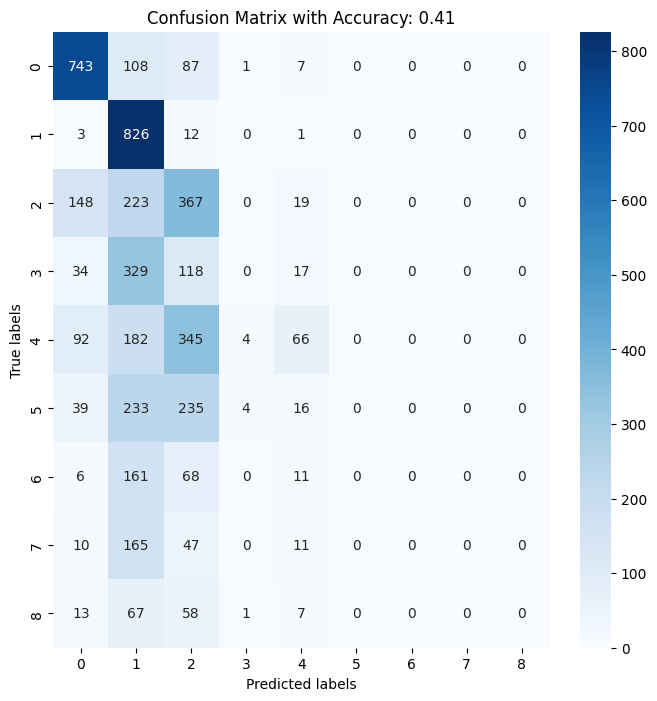

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model to get predictions
best_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in best_val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
# Plot the confusion matrix using Seaborn
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title(f'Confusion Matrix with Accuracy: {accuracy:.2f}')
ax.xaxis.set_ticklabels(range(0, 9))
ax.yaxis.set_ticklabels(range(0, 9))
plt.show()


0-946,1-842,2-757,3-498,4-689,5-527,6-246,7-233,8-146

#  Gradient Boosting Machines

In [ ]:
!pip install -q xgboost


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   5.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   4.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   4.3s
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=100; total time=   3.5s
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=100; total time=   3.4s
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=100; total time=   3.7s
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=500; total time=  16.9s
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=500; total time=  15.9s
[CV] END ..learning_rate=0.01, max_depth=9, n_est

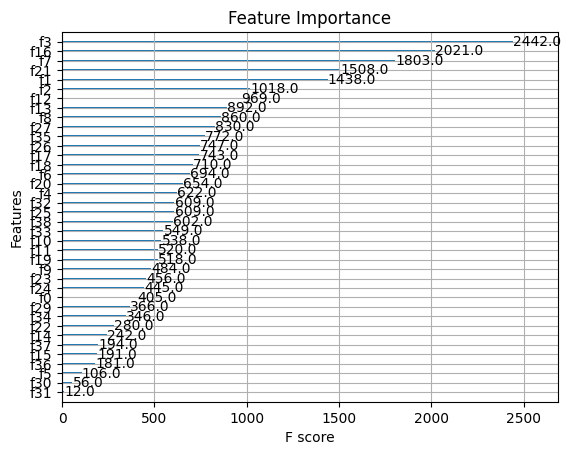

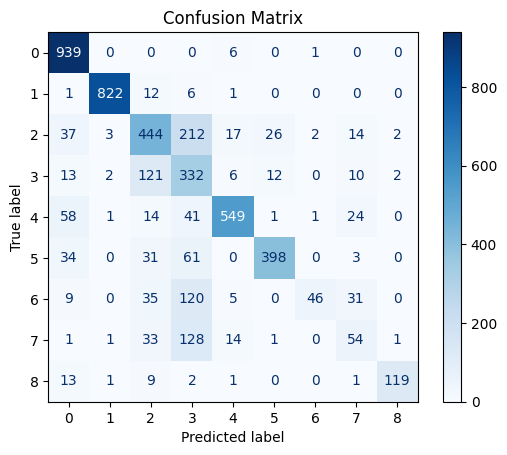

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 500],
    'max_depth': [3, 9]
}

# Initialize the model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2)

# Fit the model
grid_search.fit(X_train_imputed, y_train)
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best validation accuracy: {grid_search.best_score_}")


# Evaluate the model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_val_imputed)
test_accuracy = accuracy_score(y_val, predictions)
print(f"Test Accuracy: {test_accuracy * 100.0}%")

# which features are most influential in predicting
plot_importance(best_model)
plt.title('Feature Importance')
plt.show()

# Generate the confusion matrix
cm = confusion_matrix(y_val, predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
import numpy as np


class EnhancedLSTM(nn.Module):
    def __init__(self, input_size=39, hidden_size=128, num_layers=2, dropout_rate=0.5, num_classes=9):
        super(EnhancedLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)

        # Additional linear layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)  # New layer 1
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)  # New layer 2

        # Output layer
        self.fc3 = nn.Linear(hidden_size // 4, num_classes)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Select last time step's output feature
        out = self.dropout(out[:, -1, :])

        # Passing through the new linear layers with activation functions
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = F.relu(self.fc2(out))
        out = self.dropout(out)

        out = self.fc3(out)

        return out

# Use SMOTE for balancing the dataset
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_imputed, y_train)

# Converting to tensors
X_train_tensor = torch.tensor(X_train_balanced[:, None, :], dtype=torch.float)
y_train_tensor = torch.tensor(y_train_balanced.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_imputed[:, None, :], dtype=torch.float)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Model initialization
best_hidden_size = 128  # Example hidden size
best_num_layers = 2  # Example number of layers
best_dropout_rate = 0.5  # Example dropout rate
best_lr = 0.0001  # Example learning rate
best_batch_size = 64  # Example batch size

best_model = EnhancedLSTM(input_size=X_train_tensor.shape[2], hidden_size=best_hidden_size, num_layers=best_num_layers, dropout_rate=best_dropout_rate, num_classes=9)
optimizer = Adam(best_model.parameters(), lr=best_lr)

# DataLoader setup
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

best_train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
best_val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)




In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np


num_epochs = 10  # Number of training epochs
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    best_model.train()
    train_loss = 0.0
    for inputs, labels in best_train_loader:
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss = train_loss / len(best_train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    best_model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in best_val_loader:
            outputs = best_model(inputs)
            loss = F.cross_entropy(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
    val_loss = val_loss / len(best_val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')




Epoch 1/10, Train Loss: 2.1520, Validation Loss: 2.0964
Epoch 2/10, Train Loss: 2.1452, Validation Loss: 2.0842
Epoch 3/10, Train Loss: 2.1430, Validation Loss: 2.0858
Epoch 4/10, Train Loss: 2.1386, Validation Loss: 2.0802
Epoch 5/10, Train Loss: 2.1356, Validation Loss: 2.0697
Epoch 6/10, Train Loss: 2.1328, Validation Loss: 2.0752
Epoch 7/10, Train Loss: 2.1324, Validation Loss: 2.0750
Epoch 8/10, Train Loss: 2.1315, Validation Loss: 2.0602
Epoch 9/10, Train Loss: 2.1304, Validation Loss: 2.0676
Epoch 10/10, Train Loss: 2.1287, Validation Loss: 2.0604


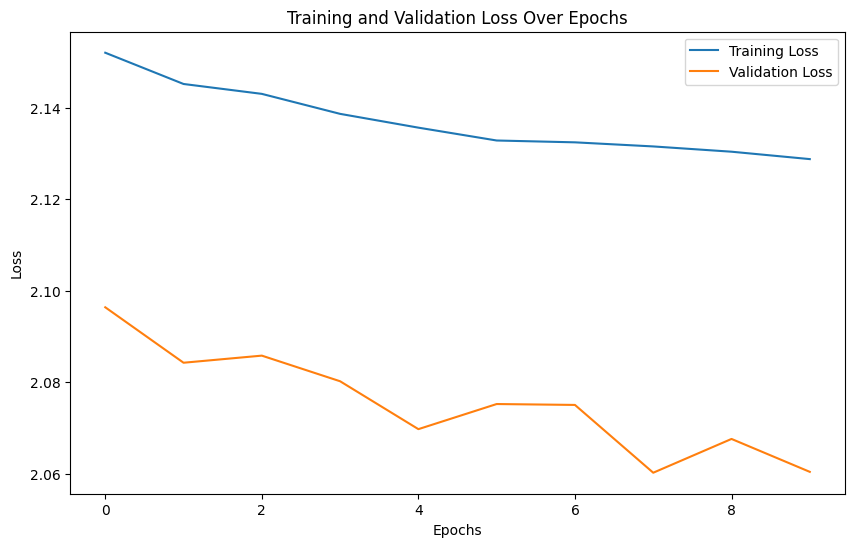

Test Accuracy: 35.401310401310404%


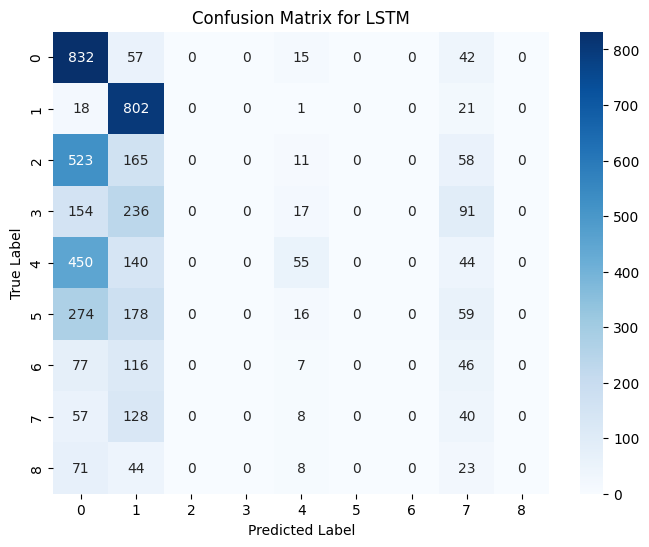

In [ ]:
from sklearn.metrics import accuracy_score
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100.0}%")
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(9)], yticklabels=[str(i) for i in range(9)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LSTM')
plt.show()

In [ ]:
1/9

0.1111111111111111